Epoch 1/100
175/175 [==============================] - 1s 2ms/step - loss: 0.0171
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 9.8673e-04
Epoch 8/100
175/175 [==============================] - 0s 2ms/step - loss: 7.7789e-04
Epoch 9/100
175/175 [==============================] - 0s 2ms/step - loss: 6.2564e-04
Epoch 10/100
175/175 [==============================] - 0s 2ms/step - loss: 5.1366e-04
Epoch 11/100
175/175 [==============================] - 0s 2ms/step - loss: 4.2522e-04
Epoch 12/100
175/175 [==============================] - 0s 2ms/step - loss: 

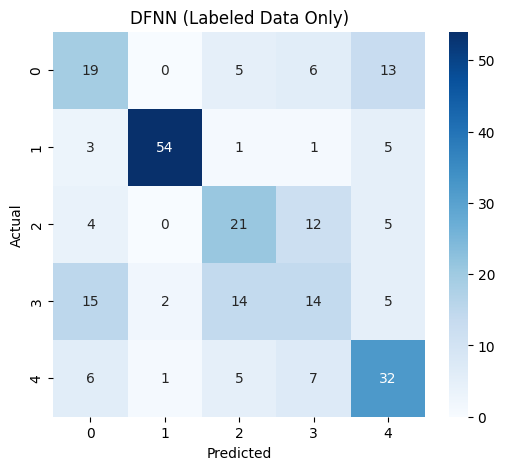

8/8 [==============================] - 0s 3ms/step
DFNN (AANN Pretrained) Accuracy: 0.5520


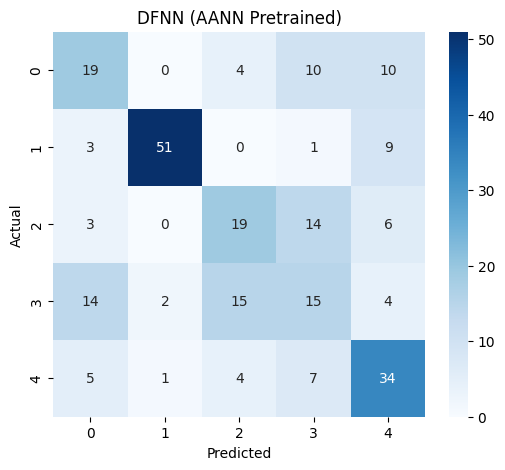

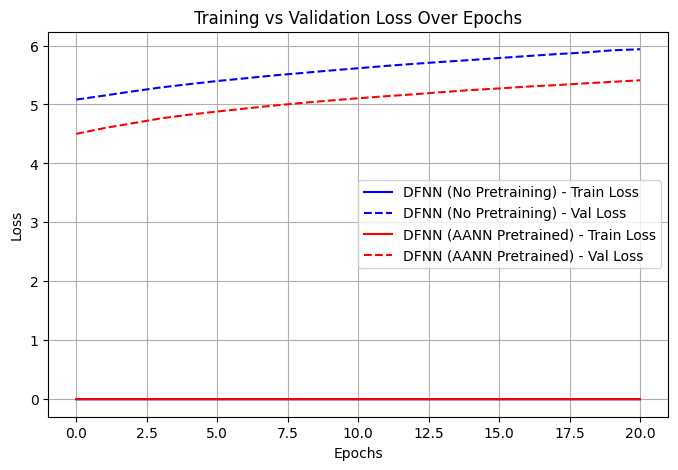


🔹 Model Performance Comparison 🔹
DFNN (Labeled Data Only) Accuracy: 0.5600
DFNN (AANN Pretrained) Accuracy: 0.5520
⚠️ AANN Pretraining did not improve performance significantly. Consider fine-tuning!


In [55]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

# =============================
# 1️⃣ Load the Dataset
# =============================
# Assuming dataset is already loaded as numpy arrays
# Replace these with actual dataset loading code
train_data_labeled = np.loadtxt("./task3/training_data_set_15_labeled_data.csv", delimiter=",")
train_labels_labeled = np.loadtxt("./task3/training_data_set_15_labeled_labels.csv", delimiter=",")
train_data_unlabeled = np.loadtxt("./task3/training_data_set_15_unlabeled.csv", delimiter=",")
val_data = np.loadtxt("./task3/validation_data_set_15_data.csv", delimiter=",")
val_labels = np.loadtxt("./task3/validation_data_set_15_labels.csv", delimiter=",")
test_data = np.loadtxt("./task3/testing_data_set_15_data.csv", delimiter=",")
test_labels = np.loadtxt("./task3/testing_data_set_15_labels.csv", delimiter=",")

# Convert labels to categorical (One-Hot Encoding)
num_classes = len(np.unique(train_labels_labeled))
train_labels_labeled = keras.utils.to_categorical(train_labels_labeled, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

input_dim = train_data_labeled.shape[1]  # Feature dimension
hidden_dims = [512, 256, 128]  # Hidden layer sizes for AANN

# =============================
# 2️⃣ Define Stacked Autoencoder (3 AEs)
# =============================
def build_autoencoder(input_dim, hidden_dim):
    input_layer = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(hidden_dim, activation="relu")(input_layer)
    decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

    autoencoder = keras.Model(input_layer, decoded)
    encoder = keras.Model(input_layer, encoded)

    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder, encoder

early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, restore_best_weights=True)

# Train AE1
ae1, enc1 = build_autoencoder(input_dim, hidden_dims[0])
ae1.fit(train_data_unlabeled, train_data_unlabeled, epochs=100, batch_size=10, shuffle=True, callbacks=[early_stopping])
print("----------------End AE1-----------------------")
# Train AE2
train_encoded_1 = enc1.predict(train_data_unlabeled)
ae2, enc2 = build_autoencoder(hidden_dims[0], hidden_dims[1])
ae2.fit(train_encoded_1, train_encoded_1, epochs=100, batch_size=10, shuffle=True, callbacks=[early_stopping])
print("----------------End AE2-----------------------")

# Train AE3
train_encoded_2 = enc2.predict(train_encoded_1)
ae3, enc3 = build_autoencoder(hidden_dims[1], hidden_dims[2])
ae3.fit(train_encoded_2, train_encoded_2, epochs=100, batch_size=10, shuffle=True, callbacks=[early_stopping])
print("----------------End AE3-----------------------")

# Final pretrained encoder
def build_pretrained_encoder():
    input_layer = keras.Input(shape=(input_dim,))
    encoded1 = enc1(input_layer)
    encoded2 = enc2(encoded1)
    encoded3 = enc3(encoded2)
    return keras.Model(input_layer, encoded3)

pretrained_encoder = build_pretrained_encoder()

# =============================
# 3️⃣ Define AANN (5-layer structure)
# Linear → Nonlinear → Linear → Nonlinear → Linear
# =============================
def build_aann(input_dim, hidden_dims):
    input_layer = keras.Input(shape=(input_dim,))
    
    # Nonlinear (ReLU)
    x = layers.Dense(hidden_dims[1], activation="relu")(x)

    # Linear
    x = layers.Dense(hidden_dims[2])(x)  

    # Nonlinear (ReLU)
    x = layers.Dense(hidden_dims[1], activation="relu")(x)

    # Linear Output
    output_layer = layers.Dense(input_dim)(x)  

    model = keras.Model(input_layer, output_layer)
    model.compile(optimizer="adam", loss="mse")
    return model

# Train AANN on Unlabeled Data
aann = build_aann(input_dim, hidden_dims)
aann.fit(train_data_unlabeled, train_data_unlabeled, epochs=100, batch_size=10, shuffle=True, callbacks=[early_stopping])
print("----------------End AANN on Unlabelled-----------------------")

# =============================
# 4️⃣ Extract Weights from AANN for DFNN
# =============================
aann_layers = aann.layers[:-1]  # Remove the last layer

# Create an encoder model from AANN
aann_encoder_input = keras.Input(shape=(input_dim,))
x = aann_layers[0](aann_encoder_input)  # Linear
x = aann_layers[1](x)  # Nonlinear (ReLU)
x = aann_layers[2](x)  # Linear
x = aann_layers[3](x)  # Nonlinear (ReLU)

pretrained_encoder = keras.Model(aann_encoder_input, x)

# =============================
# 5️⃣ Define DFNN Classifier (5-layer: Linear → Nonlinear → Nonlinear → Nonlinear → Linear)
# =============================
def build_dfnn(output_dim, use_pretrained_encoder=False):
    input_layer = keras.Input(shape=(input_dim,))
    
    x = pretrained_encoder(input_layer)  # Use AANN weights
    
    # Nonlinear Layers
    x = layers.Dense(hidden_dims[1], activation="relu")(x)  # Nonlinear
    x = layers.Dense(hidden_dims[2], activation="relu")(x)  # Nonlinear
    x = layers.Dense(hidden_dims[1], activation="relu")(x)  # Nonlinear

    # Final Linear Layer (Softmax Output)
    output_layer = layers.Dense(output_dim, activation="softmax")(x)  

    model = keras.Model(input_layer, output_layer)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# =============================
# 6️⃣ Train DFNN with Loss Tracking
# =============================

# Train DFNN (No Pretraining)
history_dfnn = dfnn.fit(train_data_labeled, train_labels_labeled, 
                        epochs=100, batch_size=10, validation_data=(val_data, val_labels), verbose=1, callbacks=[early_stopping])
print("----------------End DFNN No Pretraining----------------------")

# Train DFNN with AANN Pretraining
history_dfnn_pretrained = dfnn_pretrained.fit(train_data_labeled, train_labels_labeled, 
                                              epochs=100, batch_size=10, validation_data=(val_data, val_labels), verbose=1, callbacks=[early_stopping])

print("----------------End DFNN with AANN pre-----------------------")

# =============================
# 7️⃣ Evaluation: Confusion Matrix
# =============================
def evaluate_model(model, data, labels, title):
    """Compute accuracy and plot confusion matrix."""
    preds = np.argmax(model.predict(data), axis=1)
    true_labels = np.argmax(labels, axis=1)

    # Compute Accuracy
    acc = accuracy_score(true_labels, preds)
    print(f"{title} Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc

# Evaluate DFNN trained only on labeled data
acc_dfnn = evaluate_model(dfnn, test_data, test_labels, "DFNN (Labeled Data Only)")

# Evaluate DFNN with AANN-pretrained weights
acc_dfnn_pretrained = evaluate_model(dfnn_pretrained, test_data, test_labels, "DFNN (AANN Pretrained)")

# =============================
# 8️⃣ Plot Training Loss vs. Epochs
# =============================
def plot_loss_curves(history_dfnn, history_dfnn_pretrained, x_range=50, y_range=0.2):
    """Plot training loss over epochs for both models."""
    plt.figure(figsize=(8, 5))

    # Plot DFNN without pretraining
    plt.plot(history_dfnn.history["loss"], label="DFNN (No Pretraining) - Train Loss", color="blue", linestyle="-")
    plt.plot(history_dfnn.history["val_loss"], label="DFNN (No Pretraining) - Val Loss", color="blue", linestyle="dashed")

    # Plot DFNN with AANN pretraining
    plt.plot(history_dfnn_pretrained.history["loss"], label="DFNN (AANN Pretrained) - Train Loss", color="red", linestyle="-")
    plt.plot(history_dfnn_pretrained.history["val_loss"], label="DFNN (AANN Pretrained) - Val Loss", color="red", linestyle="dashed")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Plot the loss comparison
plot_loss_curves(history_dfnn, history_dfnn_pretrained)

# =============================
# 🔹 Model Performance Comparison 🔹
# =============================
print("\n🔹 Model Performance Comparison 🔹")
print(f"DFNN (Labeled Data Only) Accuracy: {acc_dfnn:.4f}")
print(f"DFNN (AANN Pretrained) Accuracy: {acc_dfnn_pretrained:.4f}")

if acc_dfnn_pretrained > acc_dfnn:
    print("✅ AANN Pretraining improved the DFNN performance!")
else:
    print("⚠️ AANN Pretraining did not improve performance significantly. Consider fine-tuning!")


Epoch 1/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0729
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 11/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 12/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 13/100
28/28 [=================

FileNotFoundError: [Errno 2] No such file or directory: '/home/deb/Documents/DL/CS6910/task3/C:/Users/USER/Assignment/Assignment 3/training_loss_plot.png'

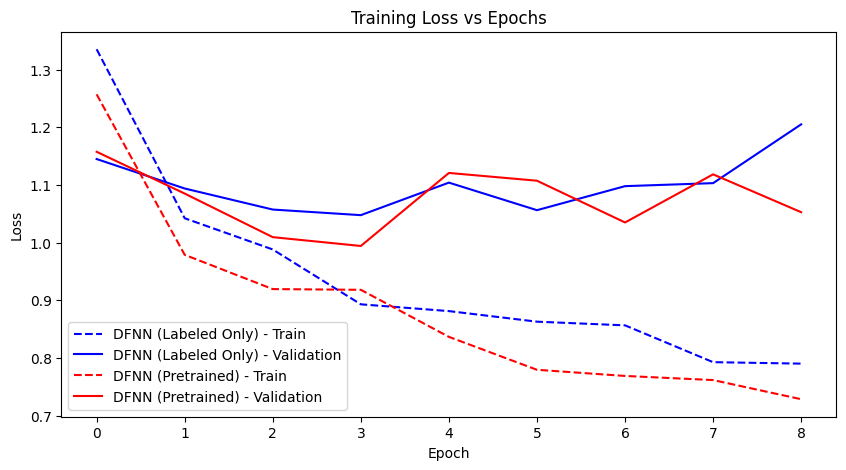

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import os

# Set dataset directory
dataset_dir = "C:/Users/USER/Assignment/Assignment 3"

# =============================
# 1️⃣ Load the Dataset
# =============================
def load_data(filename):
    return np.loadtxt(os.path.join(dataset_dir, filename), delimiter=",")

train_data_labeled = np.loadtxt("./task3/training_data_set_15_labeled_data.csv", delimiter=",")
train_labels_labeled = np.loadtxt("./task3/training_data_set_15_labeled_labels.csv", delimiter=",")
train_data_unlabeled = np.loadtxt("./task3/training_data_set_15_unlabeled.csv", delimiter=",")
val_data = np.loadtxt("./task3/validation_data_set_15_data.csv", delimiter=",")
val_labels = np.loadtxt("./task3/validation_data_set_15_labels.csv", delimiter=",")
test_data = np.loadtxt("./task3/testing_data_set_15_data.csv", delimiter=",")
test_labels = np.loadtxt("./task3/testing_data_set_15_labels.csv", delimiter=",")

# Convert labels to categorical (One-Hot Encoding)
num_classes = len(np.unique(train_labels_labeled))
train_labels_labeled = keras.utils.to_categorical(train_labels_labeled, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

input_dim = train_data_labeled.shape[1]  # Feature dimension
hidden_dims = [512, 256, 128]  # Hidden layer sizes for AANN

# =============================
# 2️⃣ Define Stacked Autoencoder
# =============================
def build_autoencoder(input_dim, hidden_dim):
    input_layer = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(hidden_dim, activation="relu")(input_layer)
    decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)
    
    autoencoder = keras.Model(input_layer, decoded)
    encoder = keras.Model(input_layer, encoded)
    
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder, encoder

# Train stacked autoencoders
ae1, enc1 = build_autoencoder(input_dim, hidden_dims[0])
ae1.fit(train_data_unlabeled, train_data_unlabeled, epochs=100, batch_size=64, shuffle=True)
train_encoded_1 = enc1.predict(train_data_unlabeled)

print("-------------------------AE1---------------------------")

ae2, enc2 = build_autoencoder(hidden_dims[0], hidden_dims[1])
ae2.fit(train_encoded_1, train_encoded_1, epochs=100, batch_size=10, shuffle=True)
train_encoded_2 = enc2.predict(train_encoded_1)

print("-------------------------AE2---------------------------")

ae3, enc3 = build_autoencoder(hidden_dims[1], hidden_dims[2])
ae3.fit(train_encoded_2, train_encoded_2, epochs=100, batch_size=10, shuffle=True)

print("-------------------------AE3---------------------------")

def build_pretrained_encoder():
    input_layer = keras.Input(shape=(input_dim,))
    encoded1 = enc1(input_layer)
    encoded2 = enc2(encoded1)
    encoded3 = enc3(encoded2)
    return keras.Model(input_layer, encoded3)

pretrained_encoder = build_pretrained_encoder()

# =============================
# 3️⃣ Define DFNN with Early Stopping
# =============================
def build_dfnn(output_dim, use_pretrained_encoder=False):
    input_layer = keras.Input(shape=(input_dim,))
    
    if use_pretrained_encoder:
        x = pretrained_encoder(input_layer)  # Use AANN weights
    else:
        x = layers.Dense(hidden_dims[0], activation="relu")(input_layer)
    
    x = layers.Dense(hidden_dims[1], activation="relu")(x)
    x = layers.Dense(hidden_dims[2], activation="relu")(x)
    x = layers.Dense(hidden_dims[1], activation="relu")(x)
    output_layer = layers.Dense(output_dim, activation="softmax")(x)
    
    model = keras.Model(input_layer, output_layer)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Early stopping criterion
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)

# Train DFNN without pretraining
dfnn = build_dfnn(num_classes, use_pretrained_encoder=False)
history_dfnn = dfnn.fit(train_data_labeled, train_labels_labeled, 
                        epochs=100, batch_size=10, validation_data=(val_data, val_labels),
                        callbacks=[early_stopping], verbose=1)

print("-------------------------DFNN without pre---------------------------")

# Train DFNN with pretraining
dfnn_pretrained = build_dfnn(num_classes, use_pretrained_encoder=True)
history_dfnn_pretrained = dfnn_pretrained.fit(train_data_labeled, train_labels_labeled, 
                                              epochs=100, batch_size=10, validation_data=(val_data, val_labels),
                                              callbacks=[early_stopping], verbose=1)
print("-------------------------DFNN pretrain---------------------------")


# =============================
# 4️⃣ Save Training Plots
# =============================
plt.figure(figsize=(10, 5))
plt.plot(history_dfnn.history['loss'], label="DFNN (Labeled Only) - Train", linestyle="dashed", color="blue")
plt.plot(history_dfnn.history['val_loss'], label="DFNN (Labeled Only) - Validation", linestyle="solid", color="blue")
plt.plot(history_dfnn_pretrained.history['loss'], label="DFNN (Pretrained) - Train", linestyle="dashed", color="red")
plt.plot(history_dfnn_pretrained.history['val_loss'], label="DFNN (Pretrained) - Validation", linestyle="solid", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss vs Epochs")
plt.show()

# =============================
# 5️⃣ Evaluation: Confusion Matrices
# =============================
def evaluate_model(model, data, labels, title, save_path):
    preds = np.argmax(model.predict(data), axis=1)
    true_labels = np.argmax(labels, axis=1)
    cm = confusion_matrix(true_labels, preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(save_path)
    plt.show()

evaluate_model(dfnn, test_data, test_labels, "DFNN (Labeled Data Only)", os.path.join(dataset_dir, "confusion_matrix_dfnn.png"))
evaluate_model(dfnn_pretrained, test_data, test_labels, "DFNN (Pretrained)", os.path.join(dataset_dir, "confusion_matrix_dfnn_pretrained.png"))